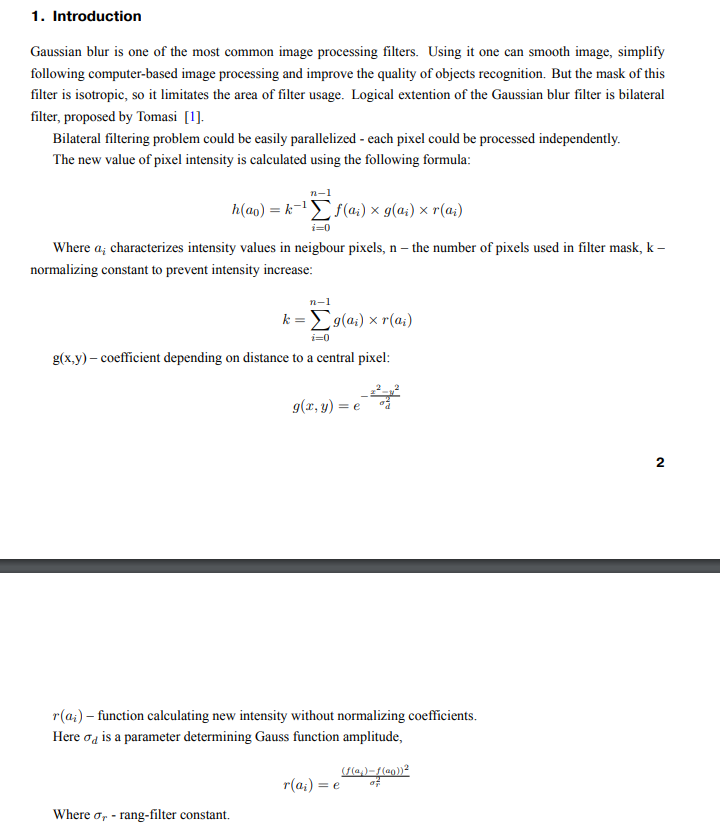

**Task defeniton**

Given the image of size M*N, implement and apply a CUDA version of 9-point bilateral filter and store the result to output image.
Missing values for edge rows and columns are to be taken from nearest pixels.
CUDA implementation must make use of texture memory.

**Proposed method**

The following method could be used to implement the bilateral filter:

1. Copy input data to device memory;
2. Bind input data to a texture link;
3. Extract each pixel together with its surrounding pixels via texture memory into 9-elements array;
4. Calculate the result pixel intensity using the formulas above;
5. Store the result into the array.

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2023.1-cp310-cp310-linux_x86_64.whl size=661263 sha256=ababa66902f4373127c2566a44cd45e1cbf96bbcbd7555556a94f69b168ad364
  Stored in directory: /root/.cache/pip/wheels/46/65/06/b997165edd2fd9690c3497ca54ea4485b571d7bd959c21c6c4
Successfully built pycuda


In [2]:
!pip install py-cpuinfo

In [31]:
!nvidia-smi

Mon Nov 13 14:23:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    27W /  70W |    115MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Требуемые библиотеки:

In [3]:
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow
from pycuda.compiler import SourceModule

Изображения я буду загружать с гугл диска и сохранять их там же

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Реализация на ЦПУ

In [30]:
def calculate_pixel(image, i, j, sigma_d, sigma_r):
    s = 0
    c = 0
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            g_coef_depend = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
            i1 = image[k, l]
            i2 = image[i, j]
            r_new_intesity = np.exp(-((i1 - i2)** 2) / sigma_r ** 2)
            c += g_coef_depend*r_new_intesity
            s += g_coef_depend*r_new_intesity*image[k, l]
    result = s / c
    return result

Вычисление новой интенсивности пикселя изображения

In [29]:
def calculate_bilateral_CPU(image, sigma_d, sigma_r):
    new_image = np.zeros(image.shape)
    width = image.shape[0]
    height = image.shape[1]
    for i in range(1, width-1):
        for j in range(1, height-1):
            new_image[i, j] = calculate_pixel(image, i, j, sigma_d, sigma_r)
    return new_image

Реализация на ГПУ

In [35]:
calculate_bilateral_GPU = SourceModule("""
texture<unsigned int, 2, cudaReadModeElementType> tex;

__global__ void bil_gpu(unsigned int * __restrict__ d_result, const int M, const int N, const float sigma_d, const float sigma_r)
{
    const int i = blockDim.x * blockIdx.x + threadIdx.x;
    const int j = blockDim.y * blockIdx.y + threadIdx.y;


    if ((i<M)&&(j<N)) {
        float s = 0;
        float c = 0;
        for (int l = i-1; l <= i+1; l++){
            for (int k = j-1; k <= j+1; k++){
                float firstImg = tex2D(tex, k, l)/255;
                float secondImg = tex2D(tex, i, j)/255;
                float g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                float r = exp(-pow((firstImg - secondImg)*255, 2) / pow(sigma_r, 2));
                c += g*r;
                s += g*r*tex2D(tex, k, l);
            }
        }
        d_result[i*N + j] = s / c;
    }


}
""")

Оригинал изображения, до обработки

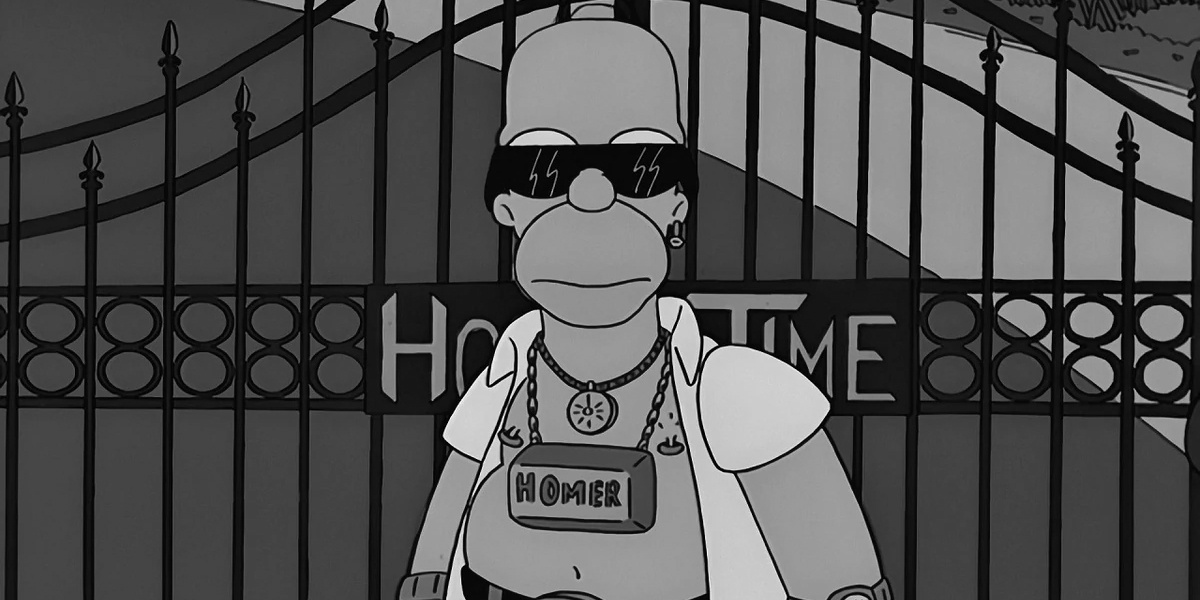

In [36]:
IMG = '/content/drive/MyDrive/MyData/image.jpg'
image = cv2.imread(IMG, cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/drive/MyDrive/MyData/original.bmp', image)
cv2_imshow(image)

The following method could be used to implement the bilateral filter:

1. Copy input data to device memory;
2. Bind input data to a texture link;
3. Extract each pixel together with its surrounding pixels via texture memory into 9-elements array;
4. Calculate the result pixel intensity using the formulas above;
5. Store the result into the array.

Для реализации двустороннего фильтра может быть использован следующий метод:

1. Скопировать входные данные в память устройства;
2. Привязка входных данных к текстурной ссылке;
3. Извлечение каждого пикселя вместе с окружающими его пикселями через текстурную память в массив из 9 элементов;
4. Вычислить интенсивность пикселей результата по приведенным выше формулам;
5. Сохранить результат в массиве.

**Bilateral filtering on GPU**

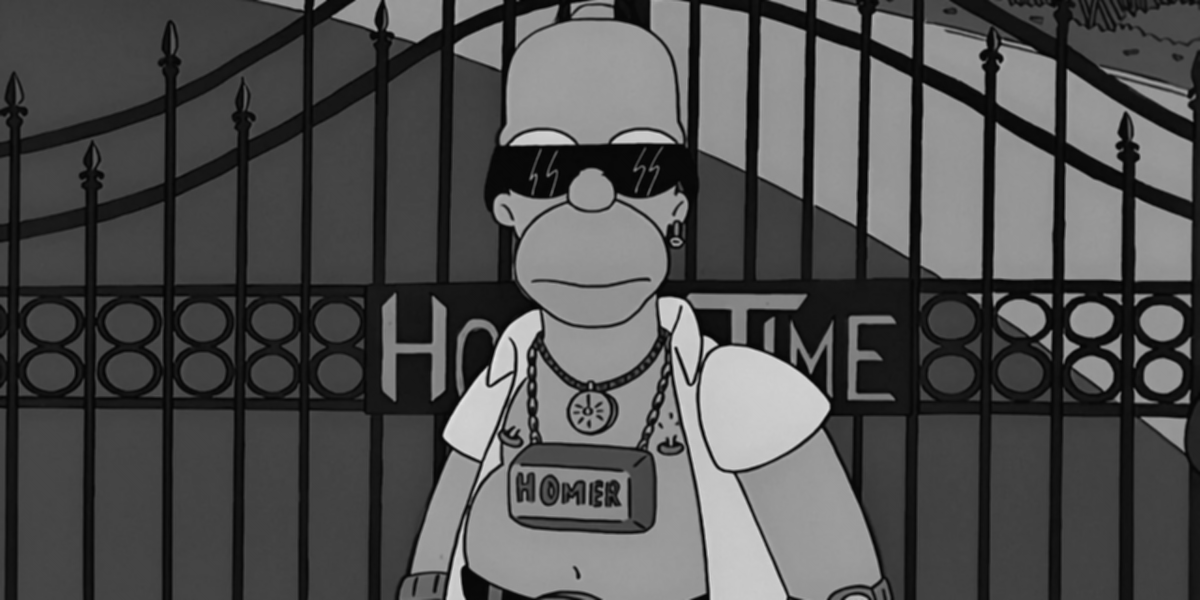

Время на GPU:  0.04947


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: array in out-of-thread context could not be cleaned up
  globals().clear()


In [40]:
gpu_result = np.zeros((M, N), dtype=np.uint32)
block = (32, 1, 1)
grid = (int(np.ceil(M/block[0])),int(np.ceil(N/block[1])))

bil_gpu = calculate_bilateral_GPU.get_function("bil_gpu")

gpu_start = time.time()

tex = calculate_bilateral_GPU.get_texref("tex")
tex.set_filter_mode(driver.filter_mode.LINEAR)
tex.set_address_mode(0, driver.address_mode.MIRROR)
tex.set_address_mode(1, driver.address_mode.MIRROR)
driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

bil_gpu(driver.Out(gpu_result), np.int32(M), np.int32(N), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[tex])

gpu_time = time.time() - gpu_start
cv2.imwrite('/content/drive/MyDrive/MyData/gpu1.bmp', gpu_result.astype(np.uint8))
cv2_imshow(gpu_result)
print('Время на GPU: ', round(gpu_time,5))

Время выполнения на GPU 0.04947

In [14]:
sigma_d = 300
sigma_r = 300
M, N = image.shape

**Bilateral filtering on CPU**

<ipython-input-30-41f09ea7ab30>:9: RuntimeWarning: overflow encountered in ubyte_scalars
  r_new_intesity = np.exp(-((i1 - i2)** 2) / sigma_r ** 2)


Изображение на CPU


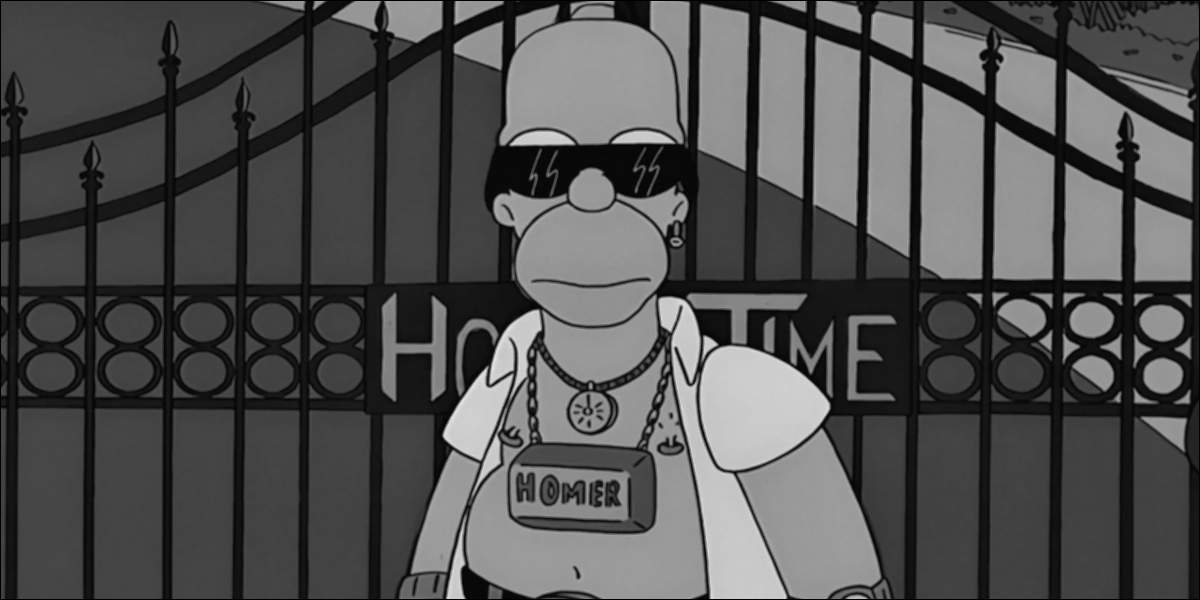

Время на CPU:  46.18258


In [38]:
cpu_start = time.time()
cpu_result = calculate_bilateral_CPU(image, sigma_d, sigma_r)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/MyData/cpu1.bmp', cpu_result)
cv2_imshow(cpu_result)
print('Время на CPU: ', round(cpu_time,5))

Время выполнения на CPU 46.18258, что в разы дольше, чем на GPU

Можно посчитать ускорение вычисления как cpu_time/gpu_time

In [39]:
print("Ускорение: ",cpu_time/gpu_time)

Ускорение:  923.454347826087


Полученное ускорение: 923.454347826087